In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
battles = pd.read_csv('dataset/battles_cleaned.csv')
battles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      38 non-null     object 
 1   year                      38 non-null     int64  
 2   battle_number             38 non-null     int64  
 3   attacker_king             36 non-null     object 
 4   defender_king             35 non-null     object 
 5   attacker_1                38 non-null     object 
 6   defender_1                37 non-null     object 
 7   attacker_outcome          38 non-null     object 
 8   battle_type               38 non-null     object 
 9   major_death               37 non-null     float64
 10  major_capture             37 non-null     float64
 11  attacker_size             24 non-null     float64
 12  defender_size             19 non-null     float64
 13  attacker_commander        37 non-null     object 
 14  defender_com

In [6]:
battles[['attacker_commander','defender_commander']].head()

,attacker_commander,defender_commander
0,Jaime Lannister,"Clement Piper, Vance"
1,Gregor Clegane,Beric Dondarrion
2,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood"
3,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist..."
4,"Robb Stark, Brynden Tully",Jaime Lannister


drop `attacker_commander` and `defender_commander` columns

In [7]:
df = battles.copy()
df.drop(columns=['attacker_commander','defender_commander'],inplace=True)

In [8]:
df.tail()

,name,year,battle_number,attacker_king,defender_king,attacker_1,defender_1,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,summer,location,region,attacker_count,defender_count,attacker_commander_count,defender_commander_count
33,Second Seige of Storm's End,300,34,Joffrey/Tommen Baratheon,Stannis Baratheon,Baratheon,Baratheon,win,siege,0.0,0.0,NaN,200.0,0.0,Storm's End,The Stormlands,1,1,2,1
34,Siege of Dragonstone,300,35,Joffrey/Tommen Baratheon,Stannis Baratheon,Baratheon,Baratheon,win,siege,0.0,0.0,2000.0,NaN,0.0,Dragonstone,The Stormlands,1,1,2,1
35,Siege of Riverrun,300,36,Joffrey/Tommen Baratheon,Robb Stark,Lannister,Tully,win,siege,0.0,0.0,3000.0,NaN,0.0,Riverrun,The Riverlands,2,1,3,1
36,Siege of Raventree,300,37,Joffrey/Tommen Baratheon,Robb Stark,Bracken,Blackwood,win,siege,0.0,1.0,1500.0,NaN,0.0,Raventree,The Riverlands,2,1,2,1
37,Siege of Winterfell,300,38,Stannis Baratheon,Joffrey/Tommen Baratheon,Baratheon,Bolton,win,siege,NaN,NaN,5000.0,8000.0,0.0,Winterfell,The North,4,2,1,1


Encode the *object* features using `LabelEncoder()`

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: le.fit_transform(x.astype(str)))

In [10]:
# for col in data:
#   if data[col].dtype=='O':
#      labelencoder = LabelEncoder()
#      data[col] = labelencoder.fit_transform(data[col].astype(str))

In [11]:
df.tail()

,name,year,battle_number,attacker_king,defender_king,attacker_1,defender_1,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,summer,location,region,attacker_count,defender_count,attacker_commander_count,defender_commander_count
33,29,300,34,1,4,0,0,1,3,0.0,0.0,NaN,200.0,0.0,22,5,1,1,2,1
34,31,300,35,1,4,0,0,1,3,0.0,0.0,2000.0,NaN,0.0,4,5,1,1,2,1
35,33,300,36,1,3,9,10,1,3,0.0,0.0,3000.0,NaN,0.0,15,4,2,1,3,1
36,32,300,37,1,3,2,1,1,3,0.0,1.0,1500.0,NaN,0.0,13,4,2,1,2,1
37,36,300,38,4,1,0,2,1,3,NaN,NaN,5000.0,8000.0,0.0,26,2,4,2,1,1


### Impute Missing Values using IterativeImputer & SimpleImputer

[Scikit-learn source code reference](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#imputing-missing-values-with-variants-of-iterativeimputer)

In [12]:
y = df['attacker_outcome']
X = df.drop(columns='attacker_outcome')

In [13]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5
br_estimator = BayesianRidge()

In [14]:
rng = np.random.RandomState(0)
# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [15]:
np.sqrt(38)

6.164414002968976

In [16]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=6)
]

score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X, y, scoring='neg_mean_squared_error',
            cv=N_SPLITS
    )

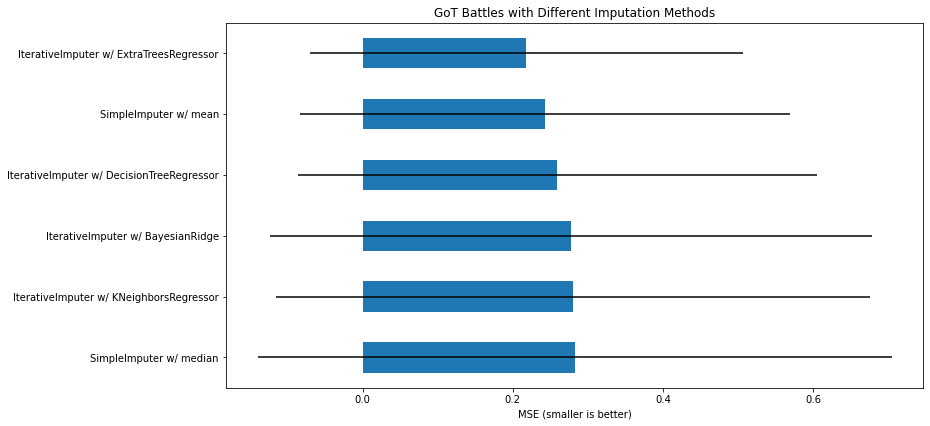

In [18]:
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean().sort_values()
errors = scores.std().sort_values()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('GoT Battles with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [21]:
scores.mean().sort_values(ascending=False)

IterativeImputer  ExtraTreesRegressor     -0.217925
SimpleImputer     mean                    -0.243091
IterativeImputer  DecisionTreeRegressor   -0.259398
                  BayesianRidge           -0.277844
                  KNeighborsRegressor     -0.279916
SimpleImputer     median                  -0.282225
dtype: float64